In [1]:
#using gensim for word embeddings and pandas for data manipulation
import gensim
import pandas as pd
from gensim import corpora
from gensim import models
from gensim import similarities

### adding libraries for wordcloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### adding libraries for store vectors & metadata
import faiss
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm


c:\Users\My-PC\miniconda3\envs\tf310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

### loading the data
df_pt = pd.read_csv("../data/potential-talents.csv")
df_pt.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
df_pt.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [4]:
### Data Preprocessing
import re
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
### EDA
columns = df_pt.columns.tolist()
id = columns[0]
job_title = columns[1]
location = columns[2]
connection = columns[3]
fit = columns[4]

for cols in [id, job_title, location, connection]:
    print(f" null values in column {cols}: {df_pt[cols].isnull().sum()}")
    # print(f"{cols}: {df_pt[cols].nunique()}")
    # print(df_pt[cols].value_counts())
    #print("\n")



 null values in column id: 0
 null values in column job_title: 0
 null values in column location: 0
 null values in column connection: 0


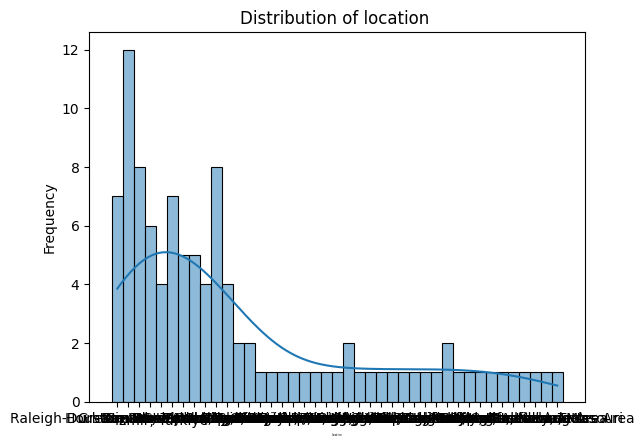

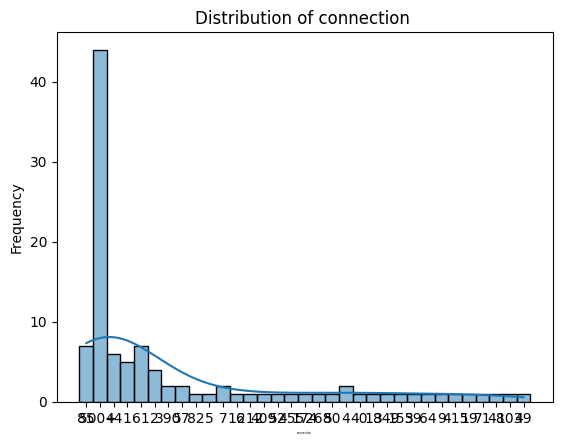

<Figure size 640x480 with 0 Axes>

In [44]:
### plotting histograms for columsn
for cols in ['location', 'connection']:
    sns.histplot(data=df_pt, x=cols, bins=10, kde=True)
    plt.title(f'Distribution of {cols} ')
    plt.xlabel(cols, fontsize= 2)
    plt.ylabel('Frequency')
    plt.show()
    plt.savefig(f'../images/{cols}_distribution.png')




In [7]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [8]:
job_title = df_pt['job_title'].apply(gensim.utils.simple_preprocess)
job_title[:5]

0    [bauer, college, of, business, graduate, magna...
1    [native, english, teacher, at, epik, english, ...
2           [aspiring, human, resources, professional]
3         [people, development, coordinator, at, ryan]
4    [advisory, board, member, at, celal, bayar, un...
Name: job_title, dtype: object

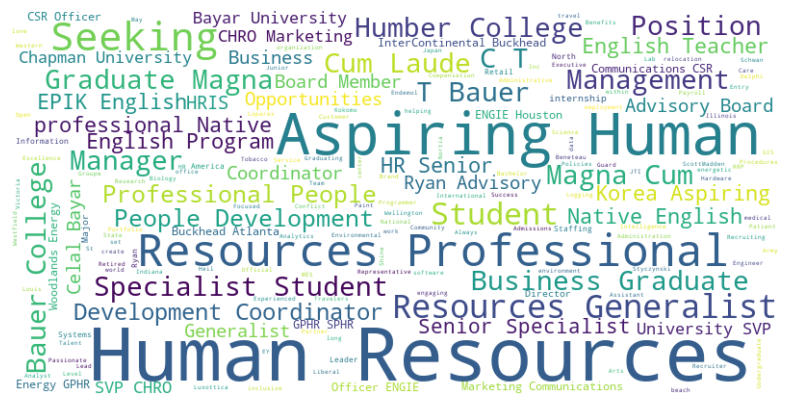

<Figure size 640x480 with 0 Axes>

In [45]:
job_titles_list = job_title.tolist()
text = " ".join(df_pt['job_title'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('../images/job_title_wordcloud.png')

In [46]:
job_title[0]

['bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

In [47]:
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'anywhere', 'third', 'however', 'show', 'put', 'sometime', 'became', 'through', 'anyone', 'those', 'out', 'so', 'empty', 'until', 'throughout', 'otherwise', 'they', 'get', 'every', 'might', 'hence', 'where', 'less', 'more', 'somewhere', 'now', 'would', 'did', 'yourselves', 'this', 'towards', 'mill', 'first', 'whereafter', 'any', 'does', 'been', 'noone', 'didn', 'thru', 'besides', 'which', 'that', 'inc', 'down', 'ever', 'no', 'after', 'across', 'something', 'detail', 'amount', 'even', 'an', 'co', 'mine', 'above', 'of', 'un', 'can', 'cry', 'due', 'cant', 'computer', 'such', 'sincere', 'former', 'beyond', 'along', 'quite', 'who', 'con', 'still', 'had', 'fire', 'her', 'only', 'behind', 'fifteen', 'nothing', 'please', 'part', 'she', 'none', 'whereas', 'again', 'somehow', 'whence', 'yet', 'made', 'nevertheless', 'latter', 'then', 'by', 'anyway', 'if', 'using', 'unless', 'becoming', 'us', 'your', 'own', 'find', 'whoever', 'nobody', 'am', 'wherein', 'per', 'must', 'or', 'done', 'ful

In [48]:
# create a set of frequently used words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
# stop_words = set('for a of the and to in'.split(' '))
# texts = [[word for word in doc if word not in stop_words] for doc in job_title]
texts = [[word for word in doc if word not in stop_words] for doc in job_title]
# count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
print(processed_corpus[:5])

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]


In [49]:
print(processed_corpus)

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university'], ['aspiring', 'human', 'resources', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['hr', 'senior', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['seeking', 'human', 'resources', 'hris', 'generalist', 'positions'], ['student', 'chapman', 'university'], ['svp', 'chro', 'marketing', 'communications', 'csr', 'officer', 'engie', 'houston', 'woodlands', 'energy', 'gphr', 'sphr'], ['human', 'resources', 'coordinator', 'buckhead', 'atlanta'], ['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resou

In [50]:

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
print(dictionary.token2id)

Dictionary<65 unique tokens: ['aspiring', 'bauer', 'business', 'college', 'cum']...>
{'aspiring': 0, 'bauer': 1, 'business': 2, 'college': 3, 'cum': 4, 'graduate': 5, 'human': 6, 'laude': 7, 'magna': 8, 'professional': 9, 'resources': 10, 'english': 11, 'epik': 12, 'korea': 13, 'native': 14, 'program': 15, 'teacher': 16, 'coordinator': 17, 'development': 18, 'people': 19, 'ryan': 20, 'advisory': 21, 'bayar': 22, 'board': 23, 'celal': 24, 'member': 25, 'university': 26, 'specialist': 27, 'generalist': 28, 'humber': 29, 'student': 30, 'hr': 31, 'senior': 32, 'hris': 33, 'positions': 34, 'seeking': 35, 'chapman': 36, 'chro': 37, 'communications': 38, 'csr': 39, 'energy': 40, 'engie': 41, 'gphr': 42, 'houston': 43, 'marketing': 44, 'officer': 45, 'sphr': 46, 'svp': 47, 'woodlands': 48, 'atlanta': 49, 'buckhead': 50, 'internship': 51, 'management': 52, 'opportunities': 53, 'manager': 54, 'retail': 55, 'staffing': 56, 'america': 57, 'director': 58, 'north': 59, 'position': 60, 'major': 61, '

In [51]:
print(len(dictionary))

65


In [52]:
bow_corpus =[dictionary.doc2bow(text) for text in processed_corpus]
print(bow_corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(0, 1), (6, 1), (9, 1), (10, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


In [53]:
# train the model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.15409025871479304), (1, 0.38181197519664134), (2, 0.31785994113068355), (3, 0.28373757014367385), (4, 0.38181197519664134), (5, 0.38181197519664134), (6, 0.07548810304306029), (7, 0.38181197519664134), (8, 0.38181197519664134), (9, 0.2332711123621775), (10, 0.07548810304306029)]
[(11, 0.6666666666666667), (12, 0.33333333333333337), (13, 0.33333333333333337), (14, 0.33333333333333337), (15, 0.33333333333333337), (16, 0.33333333333333337)]
[(0, 0.514905501818844), (6, 0.252249817106758), (9, 0.7794949542722511), (10, 0.252249817106758)]
[(17, 0.4282922112779002), (18, 0.5217169672528987), (19, 0.5217169672528987), (20, 0.5217169672528987)]
[(21, 0.42877361248588103), (22, 0.42877361248588103), (23, 0.42877361248588103), (24, 0.42877361248588103), (25, 0.42877361248588103), (26, 0.28419350129627785)]
[(0, 0.4298555394513991), (6, 0.2105842350216153), (10, 0.2105842350216153), (27, 0.8523689196138423)]
[(0, 0.24004117745157263), (3, 0.4420052311716772), (6, 0.1175950594747249), (10,

In [54]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary))

In [55]:
query_doc = "Native English Teacher at EPIK (English Program in Korea)".lower()
query_bow = dictionary.doc2bow(gensim.utils.simple_preprocess(query_doc))
similarity = index[tfidf[query_bow]]
print(similarity)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print("Top 10 similar documents (index, similarity score):")
for doc_position, doc_score in top_10:
    print(f"Document {doc_position}: Similarity Score {doc_score}")

Top 10 similar documents (index, similarity score):
Document 1: Similarity Score 1.0
Document 15: Similarity Score 1.0
Document 19: Similarity Score 1.0
Document 31: Similarity Score 1.0
Document 44: Similarity Score 1.0
Document 0: Similarity Score 0.0
Document 2: Similarity Score 0.0
Document 3: Similarity Score 0.0
Document 4: Similarity Score 0.0
Document 5: Similarity Score 0.0


In [57]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print(top_10)

[(1, 1.0), (15, 1.0), (19, 1.0), (31, 1.0), (44, 1.0), (0, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0)]


In [58]:
for i, sim in sorted(enumerate(similarity), key=lambda item: -item[1], reverse=False):
    print(f"Document {i}: Similarity {sim}")

Document 1: Similarity 1.0
Document 15: Similarity 1.0
Document 19: Similarity 1.0
Document 31: Similarity 1.0
Document 44: Similarity 1.0
Document 0: Similarity 0.0
Document 2: Similarity 0.0
Document 3: Similarity 0.0
Document 4: Similarity 0.0
Document 5: Similarity 0.0
Document 6: Similarity 0.0
Document 7: Similarity 0.0
Document 8: Similarity 0.0
Document 9: Similarity 0.0
Document 10: Similarity 0.0
Document 11: Similarity 0.0
Document 12: Similarity 0.0
Document 13: Similarity 0.0
Document 14: Similarity 0.0
Document 16: Similarity 0.0
Document 17: Similarity 0.0
Document 18: Similarity 0.0
Document 20: Similarity 0.0
Document 21: Similarity 0.0
Document 22: Similarity 0.0
Document 23: Similarity 0.0
Document 24: Similarity 0.0
Document 25: Similarity 0.0
Document 26: Similarity 0.0
Document 27: Similarity 0.0
Document 28: Similarity 0.0
Document 29: Similarity 0.0
Document 30: Similarity 0.0
Document 32: Similarity 0.0
Document 33: Similarity 0.0
Document 34: Similarity 0.0
Do

In [59]:
for doc, as_text in zip(df_pt['job_title'], top_10):
    print(f"Document: {doc} \nSimilarity Score: {as_text}\n")

Document: 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional 
Similarity Score: (1, 1.0)

Document: Native English Teacher at EPIK (English Program in Korea) 
Similarity Score: (15, 1.0)

Document: Aspiring Human Resources Professional 
Similarity Score: (19, 1.0)

Document: People Development Coordinator at Ryan 
Similarity Score: (31, 1.0)

Document: Advisory Board Member at Celal Bayar University 
Similarity Score: (44, 1.0)

Document: Aspiring Human Resources Specialist 
Similarity Score: (0, 0.0)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (2, 0.0)

Document: HR Senior Specialist 
Similarity Score: (3, 0.0)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (4, 0.0)

Document: Seeking Human Resources HRIS and Generalist Positions 
Similarity Score: (5, 0.0)



In [60]:
from sentence_transformers import SentenceTransformer, util

model_tf = SentenceTransformer("all-mpnet-base-v2")

query = "Aspiring Human Resources Professional | An energetic and Team-Focused Leader"
docs = df_pt['job_title'].tolist()
embeddings = model_tf.encode(docs, convert_to_tensor=True)
query_embedding = model_tf.encode(query, convert_to_tensor=True)

scores = util.cos_sim(query_embedding, embeddings)
### print scores of each document along with document for top 10
top_10_indices = np.argsort(-scores[0].cpu().numpy())[:10]
top_10_scores = scores[0][top_10_indices]
top_10_docs = [docs[i] for i in top_10_indices]

# for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
#     print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {docs.index(doc)}")

for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
    print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {index}")




Score: 1.0000	Document: Aspiring Human Resources Professional | An energetic and Team-Focused Leader	Index: 81
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 20
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 45
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 32
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 57
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 16
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 2
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 96
Score: 0.7780	Document: Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment	Index: 75
Score: 0.7595	Document: Aspiring Human Resources Specialist	Index: 35


In [61]:
embeddings.shape

torch.Size([104, 768])

In [62]:
np.save('pt_job_title_embeddings.npy', embeddings)

In [63]:
# loading the embeddings
embeddings = np.load('pt_job_title_embeddings.npy')

In [64]:
d = embeddings.shape[1]  # dimension of the embeddings
print(d)

768


In [65]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer

Build an index (store vector & metadata)

In [66]:
MODEL_NAME = "intfloat/e5-base-v2"   # great for retrieval; or "all-mpnet-base-v2"
INDEX_PATH = "jd.index"
META_PATH  = "jd_meta.pkl"

model = SentenceTransformer(MODEL_NAME)
docs = ["passage: " + t for t in df_pt["job_title"].tolist()]

emb = model.encode(docs, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb = emb.astype("float32")

d = emb.shape[1]  # vector dimension

# Cosine similarity = inner product when vectors are normalized
index = faiss.IndexFlatIP(d)
index.add(emb)

# Save
faiss.write_index(index, INDEX_PATH)
with open(META_PATH, "wb") as f:
    pickle.dump(df_pt.to_dict(orient="records"), f)

print(f"Indexed {index.ntotal} job descriptions. dim={d}")

Batches: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]

Indexed 104 job descriptions. dim=768


Search (semantic matching)

In [67]:
def search_by_vector(qv, top_k=10, threshold=0.6, retrieve_k=50):
    qv = normalize(qv).reshape(1, -1)
    scores, idxs = index.search(qv, retrieve_k)

    results = []
    rank = 0

    for score, i in zip(scores[0], idxs[0]):
        if i == -1 or score < threshold:
            continue

        rank += 1
        row = meta[int(i)]
        results.append({
            "rank": rank,
            "id": row.get("id"),
            "faiss_id": int(i),
            "score": round(float(score), 4),
            "job_title": row.get("job_title"),
            "location": row.get("location"),
        })

        if rank >= top_k:
            break

    return results


In [68]:
import numpy as np

def normalize(v: np.ndarray) -> np.ndarray:
     v = v.astype(np.float32)
     norm = np.linalg.norm(v)
     if norm == 0:
         return v
     return v / norm


In [69]:
## ask user for querytext input
# querytext = "Looking for a Software Engineer with experience in Python and Machine Learning."
# print(f"input query: {querytext}")


print(f'enter a job title to search:')
querytext = input()
print(f"you want to search the job title: {querytext}")

enter a job title to search:
you want to search the job title: Software engineer


In [34]:
# qv= normalize(
#     model.encode(["query: " + querytext], normalize_embeddings=True)[0]
# )

In [70]:
print (querytext)

Software engineer


In [71]:
# Load the FAISS index and metadata
index = faiss.read_index(INDEX_PATH)
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

# Create query vector from querytext
qv_base = normalize(
    model.encode(["query: " + querytext], normalize_embeddings=True)[0]
)

# Search using the query vector
results = search_by_vector(qv_base, top_k=10, threshold=0.6, retrieve_k=50)
for r in results:
    print(r)

{'rank': 1, 'id': 86, 'faiss_id': 85, 'score': 0.826, 'job_title': 'Information Systems Specialist and Programmer with a love for data and organization.', 'location': 'Gaithersburg, Maryland'}
{'rank': 2, 'id': 84, 'faiss_id': 83, 'score': 0.8204, 'job_title': 'Human Resources professional for the world leader in GIS software', 'location': 'Highland, California'}
{'rank': 3, 'id': 80, 'faiss_id': 79, 'score': 0.8093, 'job_title': 'Junior MES Engineer| Information Systems', 'location': 'Myrtle Beach, South Carolina Area'}
{'rank': 4, 'id': 90, 'faiss_id': 89, 'score': 0.7781, 'job_title': 'Undergraduate Research Assistant at Styczynski Lab', 'location': 'Greater Atlanta Area'}
{'rank': 5, 'id': 76, 'faiss_id': 75, 'score': 0.7739, 'job_title': 'Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment', 'location': 'New York, New York'}
{'rank': 6, 'id': 71, 'faiss_id': 70, 'score': 0.7728, 'job_title': 'Human Resources General

In [72]:
## pretty print results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)



[   {   'faiss_id': 85,
        'id': 86,
        'job_title': 'Information Systems Specialist and Programmer with a '
                     'love for data and organization.',
        'location': 'Gaithersburg, Maryland',
        'rank': 1,
        'score': 0.826},
    {   'faiss_id': 83,
        'id': 84,
        'job_title': 'Human Resources professional for the world leader in GIS '
                     'software',
        'location': 'Highland, California',
        'rank': 2,
        'score': 0.8204},
    {   'faiss_id': 79,
        'id': 80,
        'job_title': 'Junior MES Engineer| Information Systems',
        'location': 'Myrtle Beach, South Carolina Area',
        'rank': 3,
        'score': 0.8093},
    {   'faiss_id': 89,
        'id': 90,
        'job_title': 'Undergraduate Research Assistant at Styczynski Lab',
        'location': 'Greater Atlanta Area',
        'rank': 4,
        'score': 0.7781},
    {   'faiss_id': 75,
        'id': 76,
        'job_title': 'Aspiring Hu

In [73]:
## save from json to dataframe
import pandas as pd
df_results = pd.DataFrame(results, columns=["score","faiss_id", "id", "job_title", "location"])
df_results

,score,faiss_id,id,job_title,location
0,0.8260,85,86,Information Systems Specialist and Programmer ...,"Gaithersburg, Maryland"
1,0.8204,83,84,Human Resources professional for the world lea...,"Highland, California"
2,0.8093,79,80,Junior MES Engineer| Information Systems,"Myrtle Beach, South Carolina Area"
3,0.7781,89,90,Undergraduate Research Assistant at Styczynski...,Greater Atlanta Area
4,0.7739,75,76,Aspiring Human Resources Professional | Passio...,"New York, New York"
5,0.7728,70,71,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area"
6,0.7722,93,94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri
7,0.7682,44,45,Native English Teacher at EPIK (English Progra...,Kanada
8,0.7682,31,32,Native English Teacher at EPIK (English Progra...,Kanada
9,0.7682,19,20,Native English Teacher at EPIK (English Progra...,Kanada


In [74]:
### asking user which candiate to stare for re-rank and save to variable

print(f'enter a number between 0 and {len(results)-1} to select a candidate to re-rank:')
selected_index = int(input())


print(f'You selected candidate at index {selected_index}:')
results[ selected_index ]

enter a number between 0 and 9 to select a candidate to re-rank:
You selected candidate at index 7:


{'rank': 8,
 'id': 45,
 'faiss_id': 44,
 'score': 0.7682,
 'job_title': 'Native English Teacher at EPIK (English Program in Korea)',
 'location': 'Kanada'}

In [75]:
# starring the results for re-rank
starred_faiss_id = results[selected_index]["faiss_id"] 

In [76]:
## get starred vector from FAISS
v_star = normalize(index.reconstruct(starred_faiss_id))


In [77]:
alpha = 0.5  # trust in human feedback (0–1)

qv_reranked = normalize((1 - alpha) * qv_base + alpha * v_star)

In [78]:
#results = search_by_vector(qv_base, top_k=10, threshold=0.6, retrieve_k=50)
reranked_results = search_by_vector(qv_reranked, top_k=10, threshold=0.6, retrieve_k=50)

print("🔁 Re-ranked results:\n")
for r in reranked_results:
    print(f"#{r['rank']:2d} | score={r['score']:.3f} | {r['job_title']} ({r['location']})")

🔁 Re-ranked results:

# 1 | score=0.940 | Native English Teacher at EPIK (English Program in Korea) (Kanada)
# 2 | score=0.940 | Native English Teacher at EPIK (English Program in Korea) (Kanada)
# 3 | score=0.940 | Native English Teacher at EPIK (English Program in Korea) (Kanada)
# 4 | score=0.940 | Native English Teacher at EPIK (English Program in Korea) (Kanada)
# 5 | score=0.940 | Native English Teacher at EPIK (English Program in Korea) (Kanada)
# 6 | score=0.854 | Information Systems Specialist and Programmer with a love for data and organization. (Gaithersburg, Maryland)
# 7 | score=0.853 | Human Resources professional for the world leader in GIS software (Highland, California)
# 8 | score=0.843 | Liberal Arts Major. Aspiring Human Resources Analyst. (Baton Rouge, Louisiana Area)
# 9 | score=0.842 | Undergraduate Research Assistant at Styczynski Lab (Greater Atlanta Area)
#10 | score=0.834 | Human Resources Coordinator at InterContinental Buckhead Atlanta (Atlanta, Georgia)
